In [7]:
import pandas
import jax
import pickle
import sys
import os

import transforms3d as t3d
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3

from tqdm import tqdm

eps = 1e-3
g = 9.81

print(os.getcwd())

/Users/pedramaghazadeh/Desktop/ECE276A_PR1


In [15]:
dataset="8"
path = "."

In [16]:
def read_data(fname):
  d = []
  with open(fname, 'rb') as f:
    d = pickle.load(f, encoding='latin1')  # needed for python 3
  return d

if int(dataset) < 10:
    cfile = f"{path}/data/cam/cam{dataset}.p"
    camd = read_data(cfile)

vfile = f"{path}/data/vicon/viconRot{dataset}.p"
vicd = read_data(vfile)

In [18]:
print(f"Raw shape of rots {vicd["rots"].shape} and ts {vicd["ts"].shape}")
print(f"Processed shape of rots {vicd["rots"].shape} and ts {vicd["ts"].shape}")

Raw shape of rots (3, 3, 3407) and ts (1, 3407)
Processed shape of rots (3, 3, 3407) and ts (1, 3407)


Sanity checking the images

(240, 320, 3, 948)


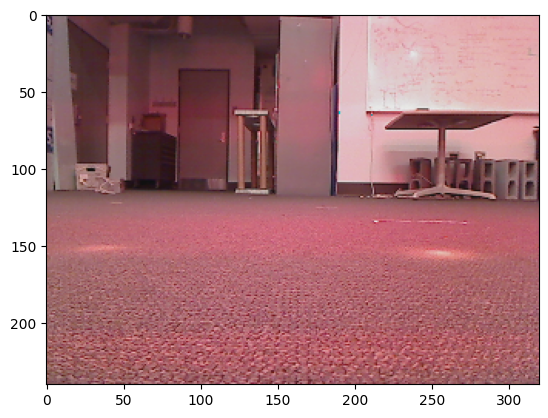

In [29]:
print(camd["cam"].shape)

plt.imshow(camd["cam"][:, :, :, 0])

Finding the closest in the past rotation matrix

In [21]:
rots = []
for i in range(len(camd["cam"])):
    for j in range(len(vicd["rots"])):
        if vicd["ts"][0][j] > camd["ts"][0][i] or j == len(vicd["rots"]) - 1:
            rots.append(vicd["rots"][j - 1])
            break
print(len(rots), len(camd["cam"]))

240 240


In [22]:
height, width = 240, 320
fov_x, fov_y = 60, 45

angles_x = np.linspace(90 - fov_x / 2, 90 + fov_x / 2, width) * np.pi / 180
angles_y = np.linspace(90 - fov_y / 2, 90 + fov_y / 2, height) * np.pi / 180

print(angles_x.shape, angles_y.shape)


(320,) (240,)


In [23]:
trigs = np.ones((height, width, 4))

for i in range(height):
    trigs[i, :, 0] = np.cos(angles_x)
    trigs[i, :, 1] = np.sin(angles_x)

for i in range(width):
    trigs[:, i, 2] = np.cos(angles_y)
    trigs[:, i, 3] = np.sin(angles_y)

In [24]:
cartesian = np.ones((height, width, 3))
cartesian[:, :, 0] = np.multiply(trigs[:, :, 0], trigs[:, :, 3])
cartesian[:, :, 1] = np.multiply(trigs[:, :, 1], trigs[:, :, 3])
cartesian[:, :, 2] = trigs[:, :, 2]

Generating panoramic images

In [ ]:
final_img = np.zeros((1000, 1000, 3), dtype=np.uint8)
rotated = cartesian

for i in tqdm(range(len(camd["cam"][0]))):
    rotated = np.dot(cartesian, rots[i])


    # norms = np.linalg.norm(rotated, axis=2)

    # Lambert azimutha equal-area projection
    spherical = np.zeros((height, width, 2))

    spherical[:, :, 0] = np.sqrt(2 / (1 - rotated[:, :, 2])) * rotated[:, :, 0]
    spherical[:, :, 1] = np.sqrt(2 / (1 - rotated[:, :, 2])) * rotated[:, :, 1]



    spherical = 250 * spherical
    spherical = spherical.astype(np.int32)
    spherical -= np.min(spherical)
    # spherical[:, :, 0] = np.arctan2(rotated[:, :, 1], rotated[:, :, 0])
    # spherical[:, :, 1] = np.arccos(rotated[:, :, 2] / norms)
     
    # spherical[:, :, 0] = (spherical[:, :, 0] + np.pi) * height / (2 * np.pi)
    # spherical[:, :, 1] = spherical[:, :, 1] * width / np.pi
    

    # spherical[:, :, 0] -= np.min(spherical[:, :, 0])
    # spherical[:, :, 1] -= np.min(spherical[:, :, 1])

    # spherical = spherical.astype(np.int32)

    for x in range(width):
        for y in range(height):
            u, v = spherical[y][x]
            print(u, v)
            final_img[v][u] = camd["cam"][x, y, :, i]
    
    del spherical
plt.imshow(final_img)

  0%|          | 0/320 [00:01<?, ?it/s]

13 15
16 17
18 19
20 21
22 23
24 25
26 28
28 30
30 32
32 34
34 36
36 38
38 40
40 42
42 44
44 46
46 48
48 50
50 52
52 54
54 56
56 58
58 60
60 61
62 63
64 65
65 67
67 69
69 71
71 73
73 75
75 77
77 78
78 80
80 82
82 84
84 86
86 87
87 89
89 91
91 93
93 94
94 96
96 98
98 99
99 101
101 103
103 104
104 106
106 108
107 109
109 111
110 112
112 114
113 115
115 117
116 118
118 120
119 121
121 123
122 124
124 125
125 127
126 128
128 129
129 131
130 132
131 133
133 134
134 136
135 137
136 138
137 139
139 140
140 142
141 143
142 144
143 145
144 146
145 147
146 148
147 149
148 150
149 150
150 151
150 152
151 153
152 154
153 155
154 155
154 156
155 157
156 157
156 158
157 159
158 159
158 160
159 160
159 161
160 161
160 162
161 162
161 163
161 163
162 164
162 164
162 164
163 164
163 165
163 165
163 165
163 165
164 165
164 165
164 166
164 166
164 166
164 166
164 166
164 166
164 165
164 165
163 165
163 165
163 165
163 165
163 164
162 164
162 164
162 163
161 163
161 163
160 162
160 162
160 161
159 161
159

IndexError: index 1000 is out of bounds for axis 0 with size 1000

Created cartesian coordinates map
Created world frame
Created lambert azimuthal projection map
Creating image:


100%|██████████| 32/32 [00:02<00:00, 15.10it/s]


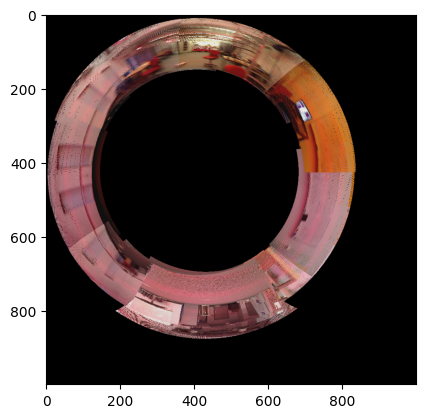

In [17]:
cam_time_map = {}
for t in camd['ts'][0]:
    temp = np.abs(vicd['ts'][0] - t)
    index = np.argmin(temp)
    cam_time_map[t] = index

H, W, vert, hor = 240, 320, 45., 60.
z_angles, x_angles = np.linspace(90-(vert/2), 90+(vert/2)-1, int(
    H)) * np.pi/180, np.linspace(90-(hor/2), 90+(hor/2)-1, int(W))*np.pi/180
cartesian_temp, cartesian = np.ones((H, W, 4)), np.ones((H, W, 3))
for i in range(z_angles.shape[0]):
    cartesian_temp[i, :, 0] = np.cos(x_angles)
for i in range(x_angles.shape[0]):
    cartesian_temp[:, i, 1] = np.cos(z_angles)
for i in range(z_angles.shape[0]):
    cartesian_temp[i, :, 2] = np.sin(x_angles)
for i in range(x_angles.shape[0]):
    cartesian_temp[:, i, 3] = np.sin(z_angles)

cartesian[:, :, 0] = np.multiply(
    cartesian_temp[:, :, 3], cartesian_temp[:, :, 0])
cartesian[:, :, 1] = np.multiply(
    cartesian_temp[:, :, 3], cartesian_temp[:, :, 2])
cartesian[:, :, 2] = cartesian_temp[:, :, 1]
print('Created cartesian coordinates map')

world_frame_cartesian = np.zeros((240, 320, 3, len(cam_time_map.keys())))
for i in range(camd['cam'].shape[3]):
    world_frame_cartesian[:, :, :, i] = np.dot(
        cartesian, vicd['rots'][:, :, cam_time_map[camd['ts'][0][i]]])
print('Created world frame')

lambert = np.zeros((240, 320, 2, len(cam_time_map.keys())))
lambert[:, :, 0, :] = np.sqrt(
    2/(1-world_frame_cartesian[:, :, 2, :])) * world_frame_cartesian[:, :, 0, :]
lambert[:, :, 1, :] = np.sqrt(
    2/(1-world_frame_cartesian[:, :, 2, :])) * world_frame_cartesian[:, :, 1, :]
abs_lamb = 250*lambert
abs_lamb = abs_lamb.astype(np.int32)
abs_lamb = abs_lamb-np.min(abs_lamb)
print('Created lambert azimuthal projection map\nCreating image:')

image = np.zeros((1000, 1000, 3)).astype(np.int32)
for r in tqdm(range(0, camd['cam'].shape[3], 30)):
    for i in range(240):
        for j in range(320):
            x, y = abs_lamb[i, j, :, r]
            image[y, x, :] = camd['cam'][i, j, :, r]
# HEIGHT, WIDTH = 240, 320
# del cartesian_temp, cartesian, z_angles, x_angles, cam_time_map

# spherical_from_cartesian = np.zeros((H, W, 3, camd['cam'].shape[3]))

# spherical_from_cartesian_r = np.linalg.norm(world_frame_cartesian, axis=2)
# spherical_from_cartesian[:, :, 0,
#                             :] = spherical_from_cartesian_r  # rho => z
# spherical_from_cartesian[:, :, 1, :] = np.arctan2(
#     world_frame_cartesian[:, :, 1, :], world_frame_cartesian[:, :, 0, :])  # theta => x
# spherical_from_cartesian[:, :, 2, :] = np.arccos(
#     world_frame_cartesian[:, :, 2, :]/spherical_from_cartesian_r)  # phi => y
# del spherical_from_cartesian_r

# sx, sy = (2*np.pi/WIDTH), (np.pi/HEIGHT)
# spherical_from_cartesian[:, :, 1, :] += np.pi
# spherical_from_cartesian[:, :, 1, :] /= sx
# spherical_from_cartesian[:, :, 2, :] /= sy
# spherical_from_cartesian[:, :, 2,
#                             :] -= np.min(spherical_from_cartesian[:, :, 2, :])
# spherical_from_cartesian[:, :, 1,
#                             :] -= np.min(spherical_from_cartesian[:, :, 1, :])
# spherical_from_cartesian = spherical_from_cartesian.astype(np.int32)
# print('Created spherical projection map\nCreating image:')

# image = np.zeros((HEIGHT, WIDTH, 3)).astype(np.int32)
# for r in tqdm(range(0, camd['cam'].shape[3], 30)):
#     for i in range(camd['cam'].shape[0]):
#         for j in range(camd['cam'].shape[1]):
#             _, x, y = spherical_from_cartesian[i, j, :, r]
#             image[y, x, :] = camd['cam'][i, j, :, r]
plt.imshow(image)


Slower approach

In [12]:
def angle_to_radian(angle):
    """
    Convert angle to radian
    input:
    angle: angle in degrees
    output:
    angle in radians
    """
    return angle * np.pi / 180

def pixel_to_angles(u, v):
    """
    Convert pixel coordinates to spherical coordinates
    inputs:
    u: x-axis pixel coordinate
    v: y-axis pixel coordinate
    output:
    theta: azimuth angle
    phi: elevation angle
    """
    return angle_to_radian(u / 60 - 30), angle_to_radian(v / 45 - 22.5)

def angles_to_unit_vector(theta, phi):
    """
    Convert spherical coordinates to unit vector
    inputs:
    theta: azimuth angle
    phi: elevation angle
    output:
    unit vector
    """
    return np.array([np.cos(theta) * np.sin(phi), np.sin(phi) * np.sin(theta), np.cos(phi)])

def unit_vector_to_angles(v):
    """
    Convert unit vector to spherical coordinates
    inputs:
    v: unit vector
    output:
    theta: azimuth angle
    phi: elevation angle
    """
    return np.arctan2(v[1], v[0]), np.arccos(v[2] / np.linalg.norm(v))

def rotate_vector(v, r):
    """
    Rotate a vector using a rotation matrix
    inputs:
    v: vector
    r: rotation matrix
    output:
    rotated vector
    """
    return np.dot(r, v)

def project_sphere_to_cylinder(v):
    """
    Project a point on the sphere to the cylinder
    inputs:
    v: point on the sphere
    output:
    point on the cylinder
    """
    theta, phi = unit_vector_to_angles(v)
    return np.array([phi, theta])

def pixel_to_cylinder(u, v, r):
    """
    Convert pixel coordinates to cylinder coordinates
    inputs:
    u: x-axis pixel coordinate
    v: y-axis pixel coordinate
    output:
    x, y: x, y coordinates on the cylinder
    """
    theta, phi = pixel_to_angles(u, v)
    v = angles_to_unit_vector(theta, phi) * depth
    v = rotate_vector(v, r)
    x, y = project_sphere_to_cylinder(v)
    print(x, y)
    return int(x * 2 * np.pi / height + np.pi) % height, int(y * np.pi / width) % width
    # print(theta, phi)
    # u, v = angle_to_pixel(phi, theta)
    # print(u, v)
    # return scale_resolution(u, v)


In [ ]:
final_img = np.zeros((int(2 * depth), int(2 * np.pi * depth), 3), dtype=np.uint8)
rot = np.eye(3)
for i in range(2):
    rot = rot @ rots[i]
    for u in range(camd["cam"].shape[1]):
        for v in range(camd["cam"].shape[2]):
            x, y = pixel_to_cylinder(u, v, rot)
            final_img[x][y] = camd["cam"][i][u][v]
            # if x != 0 or y != 0:
            #     print(x, y)
plt.imshow(final_img)